# Max K-Vertex Cover

## Introduction

The Max K-Vertex Cover problem [[1]](#MVC) is a classical problem in graph theory and computer science, where we aim to find a set of vertices such that each edge of the graph is incident to at least one vertex in the set, and the size of the set does not exceed a given number $k$.



## Mathematical Formulation
The Max-k Vertex Cover problem can be formulated as an Integer Linear Program (ILP):

Minimize:
$\sum_{(i,j) \in E} (1 - x_i)(1 - x_j)$

Subject to:
$\sum_{i \in V} x_i = k$

and
$x_i \in \{0, 1\} \quad \forall i \in V$

Where:
- $x_i$ is a binary variable that equals 1 if node $i$ is in the cover and 0 otherwise
- $E$ is the set of edges in the graph
- $V$ is the set of vertices in the graph
- $k$ is the maximum number of vertices allowed in the cover




# Solving with the Classiq platform

We go through the steps of solving the problem with the Classiq platform, using QAOA algorithm [[2](#QAOA)]. The solution is based on defining a pyomo model for the optimization problem we would like to solve.

In [1]:
from typing import cast

import networkx as nx
import numpy as np
import pyomo.core as pyo
from IPython.display import Markdown, display
from matplotlib import pyplot as plt

## Building the Pyomo model from a graph input

We proceed by defining the pyomo model that will be used on the Classiq platform, using the mathematical formulation defined above:

In [2]:
import networkx as nx
import pyomo.core as pyo


def mvc(graph: nx.Graph, k: int) -> pyo.ConcreteModel:
    model = pyo.ConcreteModel()
    model.x = pyo.Var(graph.nodes, domain=pyo.Binary)
    model.amount_constraint = pyo.Constraint(expr=sum(model.x.values()) == k)

    def obj_expression(model):
        # number of edges not covered
        return sum((1 - model.x[i]) * (1 - model.x[j]) for i, j in graph.edges)

    model.cost = pyo.Objective(rule=obj_expression, sense=pyo.minimize)

    return model

The model contains:

- Index set declarations (model.Nodes, model.Arcs).
- Binary variable declaration for each node (model.x) indicating whether the variable is chosen for the set.
- Constraint rule – ensures that the set is of size k.
- Objective rule – counts the number of edges not covered; i.e., both related variables are zero.

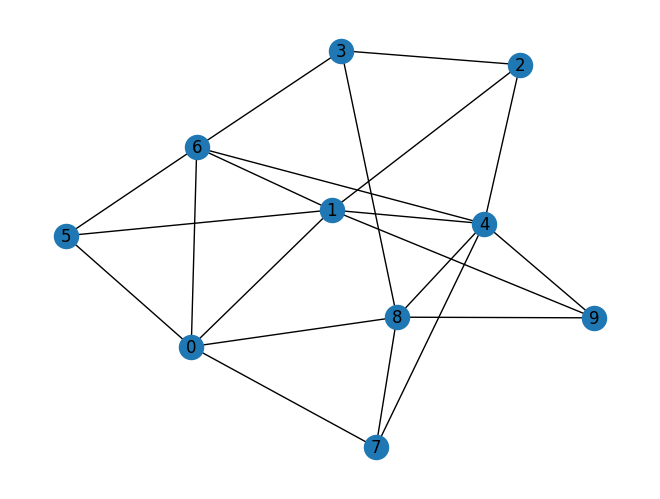

In [3]:
import networkx as nx

K = 5
num_nodes = 10
p_edge = 0.5
graph = nx.erdos_renyi_graph(n=num_nodes, p=p_edge, seed=13)

nx.draw_kamada_kawai(graph, with_labels=True)
mvc_model = mvc(graph, K)

In [4]:
mvc_model.pprint()

1 Set Declarations
    x_index : Size=1, Index=None, Ordered=False
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :   10 : {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

1 Var Declarations
    x : Size=10, Index=x_index
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          0 :     0 :  None :     1 : False :  True : Binary
          1 :     0 :  None :     1 : False :  True : Binary
          2 :     0 :  None :     1 : False :  True : Binary
          3 :     0 :  None :     1 : False :  True : Binary
          4 :     0 :  None :     1 : False :  True : Binary
          5 :     0 :  None :     1 : False :  True : Binary
          6 :     0 :  None :     1 : False :  True : Binary
          7 :     0 :  None :     1 : False :  True : Binary
          8 :     0 :  None :     1 : False :  True : Binary
          9 :     0 :  None :     1 : False :  True : Binary

1 Objective Declarations
    cost : Size=1, Index=None, Active=True
        Key  : Active : S

## Setting Up the Classiq Problem Instance

In order to solve the Pyomo model defined above, we use the Classiq combinatorial optimization engine. For the quantum part of the QAOA algorithm (`QAOAConfig`) - define the number of repetitions (`num_layers`):

In [5]:
from classiq import construct_combinatorial_optimization_model
from classiq.applications.combinatorial_optimization import OptimizerConfig, QAOAConfig

qaoa_config = QAOAConfig(num_layers=3)

For the classical optimization part of the QAOA algorithm we define the maximum number of classical iterations (`max_iteration`) and the $\alpha$-parameter (`alpha_cvar`) for running CVaR-QAOA, an improved variation of the QAOA algorithm [[3](#cvar)]:

In [6]:
optimizer_config = OptimizerConfig(max_iteration=60, alpha_cvar=0.7)

Lastly, we load the model, based on the problem and algorithm parameters, which we can use to solve the problem:

In [7]:
qmod = construct_combinatorial_optimization_model(
    pyo_model=mvc_model,
    qaoa_config=qaoa_config,
    optimizer_config=optimizer_config,
)

We also set the quantum backend we want to execute on:

In [8]:
from classiq import set_execution_preferences
from classiq.execution import ClassiqBackendPreferences, ExecutionPreferences

backend_preferences = ExecutionPreferences(
    backend_preferences=ClassiqBackendPreferences(backend_name="simulator")
)

qmod = set_execution_preferences(qmod, backend_preferences)

In [9]:
from classiq import write_qmod

write_qmod(qmod, "max_k_vertex_cover")

## Synthesizing the QAOA Circuit and Solving the Problem

We can now synthesize and view the QAOA circuit (ansatz) used to solve the optimization problem:

In [10]:
from classiq import show, synthesize

qprog = synthesize(qmod)
show(qprog)

Opening: https://platform.classiq.io/circuit/3d753f60-bd5e-40a9-9fcd-fd07cf4536e8?version=0.45.0.dev0%2Bcf1b9b7ccc


We now solve the problem by calling the `execute` function on the quantum program we have generated:

In [11]:
from classiq import execute

res = execute(qprog).result()

We can check the convergence of the run:

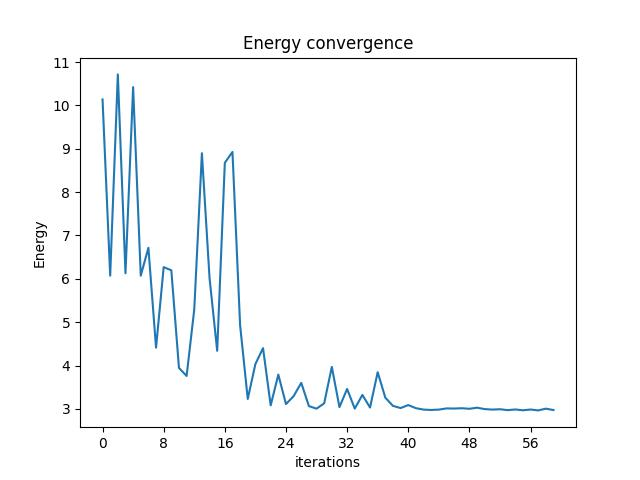

In [12]:
from classiq.execution import VQESolverResult

vqe_result = res[0].value
vqe_result.convergence_graph

# Optimization Results

We can also examine the statistics of the algorithm:

In [13]:
import pandas as pd

from classiq.applications.combinatorial_optimization import (
    get_optimization_solution_from_pyo,
)

solution = get_optimization_solution_from_pyo(
    mvc_model, vqe_result=vqe_result, penalty_energy=qaoa_config.penalty_energy
)
optimization_result = pd.DataFrame.from_records(solution)
optimization_result.sort_values(by="cost", ascending=True).head(5)

,probability,cost,solution,count
0,0.061,1.0,"[1, 1, 0, 0, 1, 0, 1, 0, 1, 0]",61
3,0.022,1.0,"[1, 1, 0, 1, 1, 0, 0, 0, 1, 0]",22
44,0.006,2.0,"[1, 1, 0, 1, 1, 1, 0, 0, 1, 0]",6
32,0.007,2.0,"[1, 1, 0, 0, 1, 1, 0, 0, 1, 0]",7
25,0.008,2.0,"[1, 1, 0, 1, 1, 0, 0, 1, 0, 0]",8


And the histogram:

array([[<Axes: title={'center': 'cost'}>]], dtype=object)

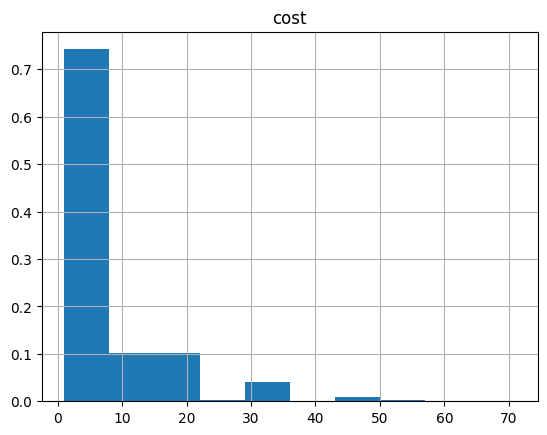

In [14]:
optimization_result.hist("cost", weights=optimization_result["probability"])

Let us plot the solution:

In [15]:
best_solution = optimization_result.solution[optimization_result.cost.idxmin()]

In [16]:
best_solution

[1, 1, 0, 0, 1, 0, 1, 0, 1, 0]

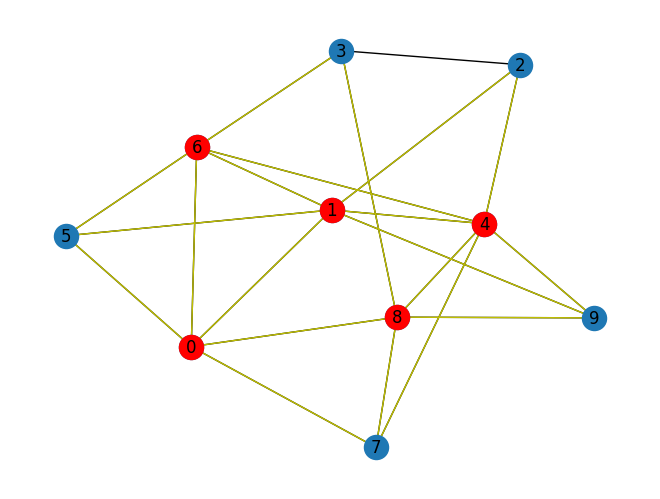

In [17]:
def draw_solution(graph: nx.Graph, solution: list):
    solution_nodes = [v for v in graph.nodes if solution[v]]
    solution_edges = [
        (u, v) for u, v in graph.edges if u in solution_nodes or v in solution_nodes
    ]
    nx.draw_kamada_kawai(graph, with_labels=True)
    nx.draw_kamada_kawai(
        graph,
        nodelist=solution_nodes,
        edgelist=solution_edges,
        node_color="r",
        edge_color="y",
    )


draw_solution(graph, best_solution)

## Comparison to a classical solver

Lastly, we can compare to the classical solution of the problem:

In [18]:
from pyomo.opt import SolverFactory

solver = SolverFactory("couenne")
solver.solve(mvc_model)
classical_solution = [int(pyo.value(mvc_model.x[i])) for i in graph.nodes]

In [19]:
classical_solution

[1, 1, 0, 1, 1, 0, 0, 0, 1, 0]

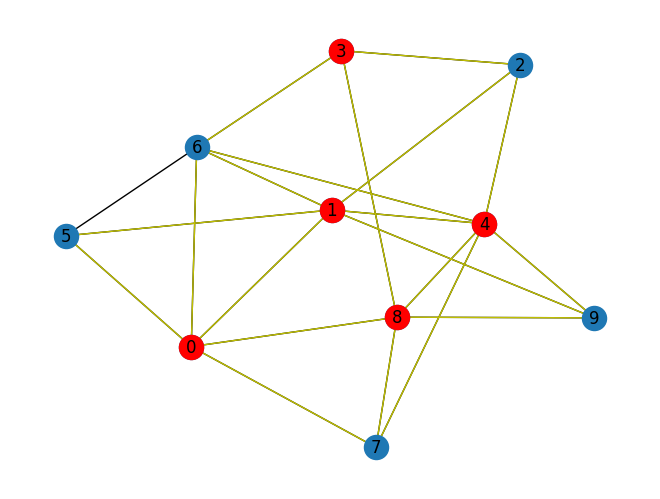

In [20]:
draw_solution(graph, classical_solution)


## References

<a id='MVC'>[1]</a>: [Max k-Vertex Cover.](https://arxiv.org/abs/1810.03792)

<a id='QAOA'>[2]</a>: [Farhi, Edward, Jeffrey Goldstone, and Sam Gutmann. "A quantum approximate optimization algorithm." arXiv preprint arXiv:1411.4028 (2014).](https://arxiv.org/abs/1411.4028)

<a id='cvar'>[3]</a>: [Barkoutsos, Panagiotis Kl, et al. "Improving variational quantum optimization using CVaR." Quantum 4 (2020): 256.](https://arxiv.org/abs/1907.04769)
